In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from xgboost.sklearn import XGBClassifier

In [2]:
url='./adult.data'
#columns name according to adult.names
cols=["age","workclass","fnlwgt","education","education-num","marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week","native-country","wage_class"]

train_set=pd.read_csv(url, names=cols)   # reading and setting names

train_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
test_set = pd.read_csv('./adult.test',skiprows = 1, header = None, names=cols)   #coz row one is multi index 

test_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


## EDA

In [4]:
train_set.isnull().sum()
   # no null values in any frame

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage_class        0
dtype: int64

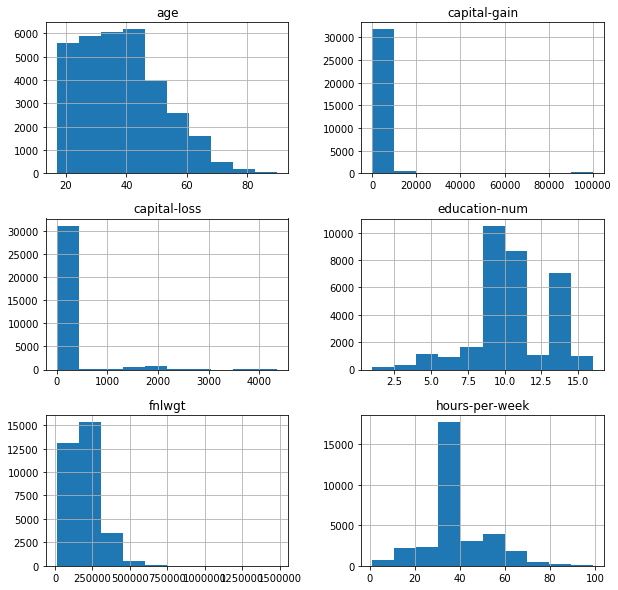

In [5]:
train_set.hist(figsize=(10,10))
plt.show()

In [6]:
train_set.dtypes  
#only 6 features(out of 14 are numeric)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
wage_class        object
dtype: object

##### checking uniqe values and count of them in each columns having type as object

In [7]:

train_set.workclass.value_counts()
#train_set.workclass.unique()       

# there is a '?'  need to be handle

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [8]:
for feature in cols:
    if train_set[feature].dtype == 'object':
        
        print('_'*10,feature, end=" ",)
        print('_'*10)
        print(train_set[feature].value_counts())
        

__________ workclass __________
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
__________ education __________
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
__________ marital-status __________
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name

**Observation:** features `Native_counrty, Occupation, workclass` having '?' as one value need to be handle

get index of the ? in the above mentioned columns

#### some features name containing `-` in the name remove or replace with `underscore`

In [11]:
train_set.columns  

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'wage_class'],
      dtype='object')

##### using regular expression

In [12]:
import re
train_set.rename(columns=lambda name: re.sub(r"\-",'_',name), inplace=True)  

In [13]:
filter1 = train_set["workclass"]=="?"
#index= train_set.where(filter1).index
index = train_set[train_set["native_country"]== ' ?'].index
#index.value_counts()  # to display all the indexes having value '?'
index.value_counts().sum()  # sum of those indexes 
# type(index)

583

In [14]:
#now apply the filter for the '?' value in those above 3 columns

indexes_list = [] # will contain three index series of desired syntexes
def filter_questionMark(l):
    
    for item in l:
        print('_'*10,item, '_'*10)
        index = train_set[train_set[item]== ' ?'].index
        indexes_list.append(index)
        #index.value_counts()  # to display all the indexes having value '?'
        print("Total `?` in {0}: {1}".format(item, index.value_counts().sum()))  # sum of those indexes 
        print("Total % of `?` in {0}: {1}".format(item, round((index.value_counts().sum()/train_set.shape[0])*100,2)))
        
filter2= ['workclass','occupation', 'native_country']
filter_questionMark(filter2)


__________ workclass __________
Total `?` in workclass: 1836
Total % of `?` in workclass: 5.64
__________ occupation __________
Total `?` in occupation: 1843
Total % of `?` in occupation: 5.66
__________ native_country __________
Total `?` in native_country: 583
Total % of `?` in native_country: 1.79


**Observation:** Max % of having `?` is 5.66 we can drop and can check how much it is affedting our data

In [15]:
print("Original Shape of Train Set:", train_set.shape)
print("Rows in Train Set:", train_set.shape[0])


Original Shape of Train Set: (32561, 15)
Rows in Train Set: 32561


In [16]:
print('\n Drowping `?` indexes from `workclass` featutre....')
train_set= train_set.drop(index)
print("Total New rows:",train_set.shape[0])



 Drowping `?` indexes from `workclass` featutre....
Total New rows: 31978


In [17]:
print('\n Drowping `?` indexes from `native_country` featutre....')
index1= train_set[train_set["native_country"]== ' ?'].index
train_set = train_set.drop(index1)
print("Total New rows:",train_set.shape[0])



 Drowping `?` indexes from `native_country` featutre....
Total New rows: 31978


In [18]:
print('\n Drowping `?` indexes from `occupation` featutre....')
index2 = train_set[train_set["occupation"]== ' ?'].index
train_set = train_set.drop(index2)
print("Total New rows:",train_set.shape[0])



 Drowping `?` indexes from `occupation` featutre....
Total New rows: 30162


In [19]:
# check for '?' again
filter_questionMark(filter2)

__________ workclass __________
Total `?` in workclass: 0
Total % of `?` in workclass: 0.0
__________ occupation __________
Total `?` in occupation: 0
Total % of `?` in occupation: 0.0
__________ native_country __________
Total `?` in native_country: 0
Total % of `?` in native_country: 0.0


**Note:** As XGBoost dnt support categorical data we need to use one hot coding tochange all object type features to numeric

#### Applying one hot coding to all the categorical variables

In [20]:
df1 = train_set.copy()

objectFeature = []
for i in list(df1.columns):
    if (df1[i].dtypes == 'object'):
        objectFeature.append(i)
        

df1=pd.get_dummies(df1[objectFeature[:-1]])


In [21]:
intFeature = []
for i in list(train_set.columns):
    if (train_set[i].dtypes == 'int64'):
        intFeature.append(i)

df2 = train_set[intFeature]

In [22]:
print(df1.shape)
print(df2.shape)

(30162, 98)
(30162, 6)


## Concatinating the two frames 

In [23]:
X_train = pd.concat([df1, df2], axis=1)

In [24]:
X_train.shape   # final dataframe to be get Trained 

(30162, 104)

In [25]:
y=train_set[objectFeature[-1]]


### Using LabelEncoder over the target variable

In [38]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# le.fit(y)
# le.classes_   # will display only two classes---> array([' <=50K', ' >50K'], dtype=object)y_train
y_train=le.fit_transform(y)





In [40]:
y_train

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

same process we can apply with the test data to prepare it for test input, secondly we have combined both and performed same operations and later divied again into train and test split


i am using same from the training portion to demonstrate model

# Applying XGB : the sklearn way

In [51]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [67]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': .5,
    'silent': True,    # would be boolean in sklearn
    'n_estimators': 100
}

In [41]:
x_train, x_test, y_t1, y_t2 =train_test_split(X_train, y_train, test_size=.25)

In [42]:
x_train.shape, x_test.shape, y_t1.shape, y_t2.shape

((22621, 104), (7541, 104), (22621,), (7541,))

#### Model Training : making model 1

In [77]:
xgb = XGBClassifier(**params).fit(x_train,y_t1)

In [65]:
y_pred= xgb.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [68]:
accuracy_score(y_t2, y_pred)

0.8636785572205278

#### Making model no .2

In [70]:
eval_set = [(x_train,y_t1), (x_test, y_t2)]
xgb1 = XGBClassifier(**params).fit(x_train,y_t1,
                                   early_stopping_rounds=15, 
                                   eval_metric=["error", "logloss"], 
                                   eval_set=eval_set,
                                   verbose=True)

[0]	validation_0-error:0.173688	validation_0-logloss:0.505545	validation_1-error:0.182071	validation_1-logloss:0.509117
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.158083	validation_0-logloss:0.433745	validation_1-error:0.1647	validation_1-logloss:0.438442
[2]	validation_0-error:0.161001	validation_0-logloss:0.398842	validation_1-error:0.168413	validation_1-logloss:0.407627
[3]	validation_0-error:0.15406	validation_0-logloss:0.375089	validation_1-error:0.162313	validation_1-logloss:0.384389
[4]	validation_0-error:0.151143	validation_0-logloss:0.360613	validation_1-error:0.158865	validation_1-logloss:0.370506
[5]	validation_0-error:0.151452	validation_0-logloss:0.350334	validation_1-error:0.158732	validation_1-logloss:0.360873
[6]	validation_0-error:0.150966	validation_0-logloss:0.342598	validation_1-error:0.156611	validation_1-logloss:0.35344

[67]	validation_0-error:0.127448	validation_0-logloss:0.280641	validation_1-error:0.139504	validation_1-logloss:0.29981
[68]	validation_0-error:0.127404	validation_0-logloss:0.280495	validation_1-error:0.139239	validation_1-logloss:0.299949
[69]	validation_0-error:0.127315	validation_0-logloss:0.280352	validation_1-error:0.138841	validation_1-logloss:0.299694
[70]	validation_0-error:0.126785	validation_0-logloss:0.280181	validation_1-error:0.138443	validation_1-logloss:0.299804
[71]	validation_0-error:0.126785	validation_0-logloss:0.280106	validation_1-error:0.138576	validation_1-logloss:0.299831
[72]	validation_0-error:0.126608	validation_0-logloss:0.279944	validation_1-error:0.139106	validation_1-logloss:0.300057
[73]	validation_0-error:0.126829	validation_0-logloss:0.279685	validation_1-error:0.139106	validation_1-logloss:0.299987
[74]	validation_0-error:0.126829	validation_0-logloss:0.279601	validation_1-error:0.139106	validation_1-logloss:0.299927
[75]	validation_0-error:0.126741	

**n_estimators — the number of runs XGBoost will try to learn**

**learning_rate — learning speed**

**early_stopping_rounds — overfitting prevention, stop early if no improvement in learning**

In [72]:
y_pred1=xgb1.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [74]:
accuracy_score(y_t2, y_pred1)

0.8626176899615435

## Ploting Classifying errors and log loss with respect to each iteration

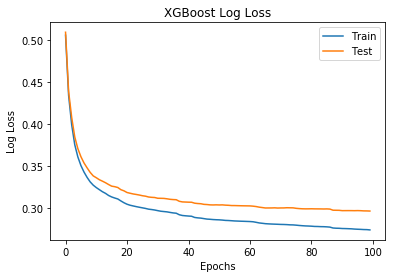

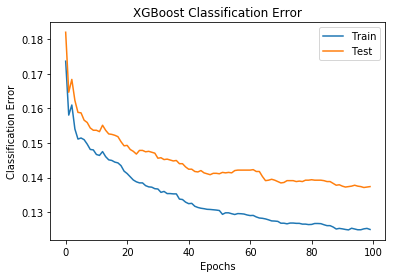

In [80]:
# retrieve performance metrics
results = xgb1.evals_result()
epochs = len(results['validation_0']['error'])
x = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x, results['validation_0']['logloss'], label='Train')
ax.plot(x, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x, results['validation_0']['error'], label='Train')
ax.plot(x, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

### model no. 3

In [81]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 20,
    'learning_rate': .01,
    'silent': True,    # would be boolean in sklearn
    'n_estimators': 200
}

In [82]:
eval_set = [(x_train,y_t1), (x_test, y_t2)]
xgb1 = XGBClassifier(**params).fit(x_train,y_t1,
                                   early_stopping_rounds=15, 
                                   eval_metric=["error", "logloss"], 
                                   eval_set=eval_set,
                                   verbose=True)

[0]	validation_0-error:0.097343	validation_0-logloss:0.686355	validation_1-error:0.169871	validation_1-logloss:0.687179
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.096326	validation_0-logloss:0.679757	validation_1-error:0.166689	validation_1-logloss:0.681326
[2]	validation_0-error:0.096105	validation_0-logloss:0.673171	validation_1-error:0.163506	validation_1-logloss:0.675565
[3]	validation_0-error:0.096194	validation_0-logloss:0.666845	validation_1-error:0.163506	validation_1-logloss:0.669935
[4]	validation_0-error:0.094868	validation_0-logloss:0.660509	validation_1-error:0.162445	validation_1-logloss:0.664406
[5]	validation_0-error:0.094779	validation_0-logloss:0.654379	validation_1-error:0.160854	validation_1-logloss:0.658993
[6]	validation_0-error:0.095221	validation_0-logloss:0.648365	validation_1-error:0.160854	validation_1-logloss:0.65

[67]	validation_0-error:0.081517	validation_0-logloss:0.411938	validation_1-error:0.153958	validation_1-logloss:0.456401
[68]	validation_0-error:0.080942	validation_0-logloss:0.409379	validation_1-error:0.153693	validation_1-logloss:0.45451
[69]	validation_0-error:0.080766	validation_0-logloss:0.406858	validation_1-error:0.153826	validation_1-logloss:0.452677
[70]	validation_0-error:0.080235	validation_0-logloss:0.404427	validation_1-error:0.153561	validation_1-logloss:0.45082
[71]	validation_0-error:0.079616	validation_0-logloss:0.401994	validation_1-error:0.153163	validation_1-logloss:0.449032
[72]	validation_0-error:0.079395	validation_0-logloss:0.399606	validation_1-error:0.152897	validation_1-logloss:0.447242
[73]	validation_0-error:0.078688	validation_0-logloss:0.397211	validation_1-error:0.152765	validation_1-logloss:0.445493
[74]	validation_0-error:0.078688	validation_0-logloss:0.394902	validation_1-error:0.153295	validation_1-logloss:0.443762
[75]	validation_0-error:0.078644	v

[135]	validation_0-error:0.070112	validation_0-logloss:0.291949	validation_1-error:0.150643	validation_1-logloss:0.372169
[136]	validation_0-error:0.069891	validation_0-logloss:0.290769	validation_1-error:0.150908	validation_1-logloss:0.371412
[137]	validation_0-error:0.069802	validation_0-logloss:0.289558	validation_1-error:0.151041	validation_1-logloss:0.370642
[138]	validation_0-error:0.069802	validation_0-logloss:0.288357	validation_1-error:0.150776	validation_1-logloss:0.369875
[139]	validation_0-error:0.069405	validation_0-logloss:0.287116	validation_1-error:0.150643	validation_1-logloss:0.369163
[140]	validation_0-error:0.069449	validation_0-logloss:0.285943	validation_1-error:0.150511	validation_1-logloss:0.368416
[141]	validation_0-error:0.069139	validation_0-logloss:0.28478	validation_1-error:0.150908	validation_1-logloss:0.367704
[142]	validation_0-error:0.069139	validation_0-logloss:0.283636	validation_1-error:0.150245	validation_1-logloss:0.367019
[143]	validation_0-error:

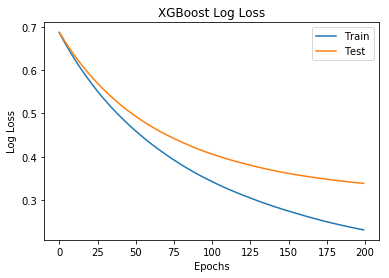

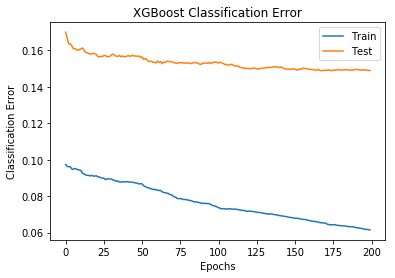

In [83]:
#plot
# retrieve performance metrics
results = xgb1.evals_result()
epochs = len(results['validation_0']['error'])
x = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x, results['validation_0']['logloss'], label='Train')
ax.plot(x, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x, results['validation_0']['error'], label='Train')
ax.plot(x, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

###### Observation

By adjusting parameter we can improve over accuracy,

## The XGBoost way

In [86]:
#Import Xgboost
import xgboost as xgb

In [89]:
dtrain = xgb.DMatrix(x_train, label = y_t1)
dtest = xgb.DMatrix(x_test, label = y_t2)

In [90]:
#creating watchlist of training
# to see out output 
watchlist = [(dtrain,'train'),(dtest, 'eval')]

In [92]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 1.0,
    'silent': True,    # would be boolean in sklearn
    'booster' : 'gbtree',
    'max_depth' : 7,
    'eval_metric' : 'auc'
}
# using bydeafault eta [default=0.3, alias: learning_rate]

num_rounds = 100  

In [94]:
model_xgb = xgb.train(params, dtrain, num_rounds, evals = watchlist, early_stopping_rounds = 15, verbose_eval = True)

[0]	train-auc:0.906542	eval-auc:0.894344
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.921503	eval-auc:0.906081
[2]	train-auc:0.926214	eval-auc:0.910136
[3]	train-auc:0.931727	eval-auc:0.911489
[4]	train-auc:0.935094	eval-auc:0.915321
[5]	train-auc:0.93845	eval-auc:0.914611
[6]	train-auc:0.941157	eval-auc:0.913968
[7]	train-auc:0.943489	eval-auc:0.913971
[8]	train-auc:0.944037	eval-auc:0.914271
[9]	train-auc:0.944881	eval-auc:0.914254
[10]	train-auc:0.946094	eval-auc:0.916483
[11]	train-auc:0.947062	eval-auc:0.917142
[12]	train-auc:0.94912	eval-auc:0.916566
[13]	train-auc:0.950668	eval-auc:0.916304
[14]	train-auc:0.95156	eval-auc:0.915887
[15]	train-auc:0.952342	eval-auc:0.915621
[16]	train-auc:0.95384	eval-auc:0.915208
[17]	train-auc:0.955571	eval-auc:0.915091
[18]	train-auc:0.957111	eval-auc:0.914597
[19]	train-auc:0.958293	eval-auc:0.914076
[20]	train-auc:0.959855	eval-auc:

The train-auc:0.94706   and Test-auc:0.917142

In [100]:
features_contribution = pd.Series(model_xgb.get_fscore()).sort_values(ascending=False)

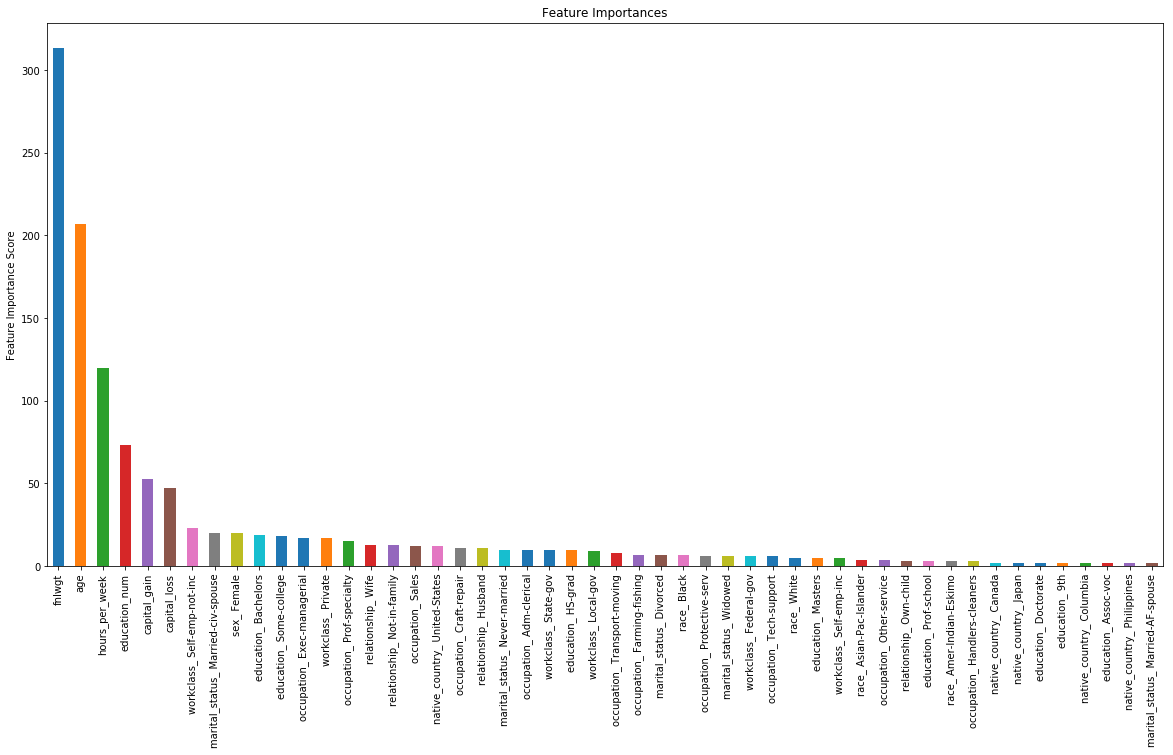

In [107]:
plt.figure(figsize=(20,10))
features_contribution[:50].plot(kind='bar', title='Feature Importances')
#features_contribution[:50].plot(kind='line')
plt.ylabel('Feature Importance Score')
plt.show()

https://xgboost.readthedocs.io/en/latest/parameter.html